In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
# Try reading the file with a different encoding
file_path = 'D:\Program Files\PFE\SA_pipline\Airline-Sentiment-2-w-AA.csv'

# Try with 'latin1' encoding
try:
    data = pd.read_csv(file_path, encoding='latin1')
except UnicodeDecodeError:
    # Try with 'iso-8859-1' encoding if 'latin1' fails
    data = pd.read_csv(file_path, encoding='iso-8859-1')

In [5]:
# Split the dataset into training and testing sets
X = data['text']
y = data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model architecture
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
293/293 [==============================] - 93s 302ms/step - loss: 0.6823 - accuracy: 0.7144 - val_loss: 0.5427 - val_accuracy: 0.7862
Epoch 2/10
293/293 [==============================] - 97s 331ms/step - loss: 0.4119 - accuracy: 0.8430 - val_loss: 0.5716 - val_accuracy: 0.7695
Epoch 3/10
293/293 [==============================] - 88s 302ms/step - loss: 0.2712 - accuracy: 0.9029 - val_loss: 0.6124 - val_accuracy: 0.7768
Epoch 4/10
293/293 [==============================] - 101s 344ms/step - loss: 0.1862 - accuracy: 0.9363 - val_loss: 0.7686 - val_accuracy: 0.7717
Epoch 5/10
293/293 [==============================] - 96s 328ms/step - loss: 0.1402 - accuracy: 0.9505 - val_loss: 0.8017 - val_accuracy: 0.7862
Epoch 6/10
293/293 [==============================] - 100s 341ms/step - loss: 0.0970 - accuracy: 0.9682 - val_loss: 0.8930 - val_accuracy: 0.7687
Epoch 7/10
293/293 [==============================] - 96s 328ms/step - loss: 0.0781 - accuracy: 0.9761 - val_loss: 0.9137 - val_

In [7]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test_pad, y_test_enc)
print(f'Test Accuracy: {test_acc}')

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = predictions.argmax(axis=1)

# Decode the predicted labels
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)

# Display some predictions
for i in range(5):
    print(f'Text: {X_test.iloc[i]}')
    print(f'Actual Sentiment: {y_test.iloc[i]}')
    print(f'Predicted Sentiment: {predicted_sentiments[i]}')
    print('---')


92/92 [==============================] - 8s 92ms/step - loss: 1.1090 - accuracy: 0.7684
Test Accuracy: 0.7684426307678223
92/92 [==============================] - 10s 94ms/step
Text: @SouthwestAir you're my early frontrunner for best airline! #oscars2016
Actual Sentiment: positive
Predicted Sentiment: positive
---
Text: @USAirways how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?
Actual Sentiment: negative
Predicted Sentiment: negative
---
Text: @JetBlue what is going on with your BDL to DCA flights yesterday and today?! Why is every single one getting delayed?
Actual Sentiment: negative
Predicted Sentiment: negative
---
Text: @JetBlue do they have to depart from Washington, D.C.??
Actual Sentiment: neutral
Predicted Sentiment: neutral
---
Text: @JetBlue I can probably find some of them. Are the ticket #s on there?
Actual Sentiment: negative
Predicted Sentiment: neutral
---


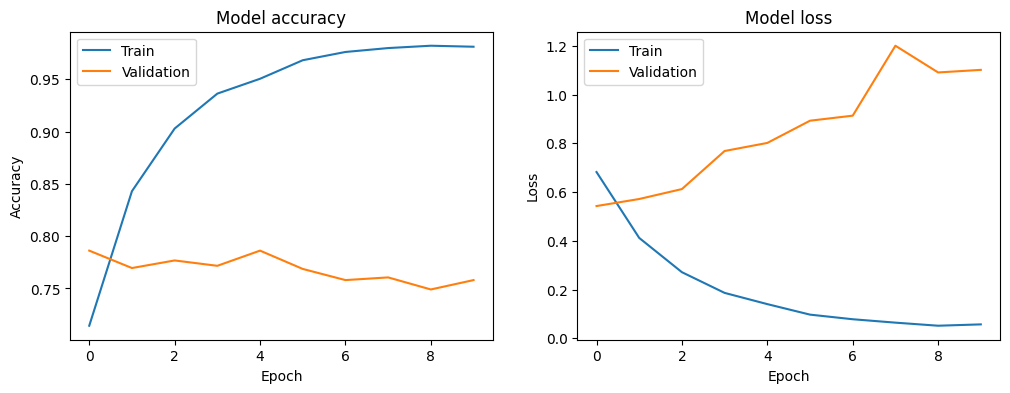

92/92 [==============================] - 8s 90ms/step


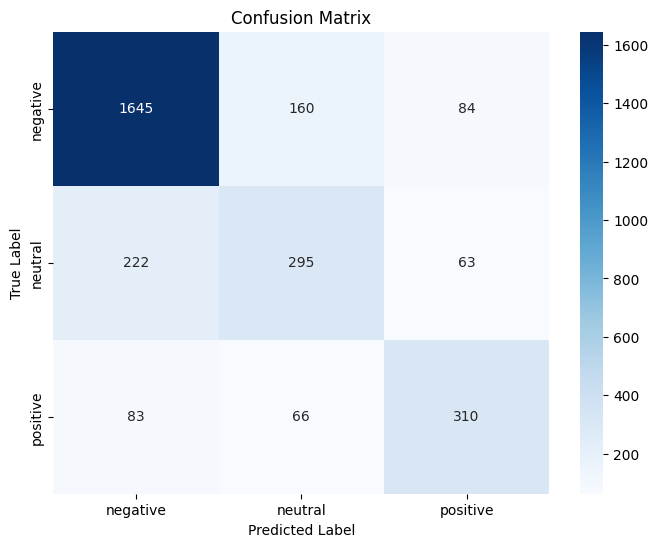

              precision    recall  f1-score   support

    negative       0.84      0.87      0.86      1889
     neutral       0.57      0.51      0.54       580
    positive       0.68      0.68      0.68       459

    accuracy                           0.77      2928
   macro avg       0.70      0.68      0.69      2928
weighted avg       0.76      0.77      0.77      2928



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot the learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot learning curve
plot_learning_curve(history)

# Compute confusion matrix
y_pred = model.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test_enc, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm, label_encoder.classes_)

# Print classification report
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
